## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/EmotionRecognition"

/content/drive/.shortcut-targets-by-id/1vpTNbX0tgYk-gzgh-1O3GSaeexpEyo4L/EmotionRecognition


In [3]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 23.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import re
import datetime
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import mediapipe as mp

from face_extraction_v2 import extract_faces



In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
model_name = 'inception_model'

if model_name == 'resnet_model':
    IMG_SIZE = 224
elif model_name == 'inception_model':
    IMG_SIZE = 299
elif model_name == 'inception_resnet_model':
    IMG_SIZE = 299
else:
    IMG_SIZE = 224

IMAGE_SIZE = (IMG_SIZE,IMG_SIZE)


EPOCHS = 40
batch_size = 32
random_seed = 2024


learning_rate = 0.0001
weight_decay = 0.0001

## Train Test Split

In [ ]:
# # For pretrain
# dataset_dir = 'pretrain_dataset'

# emotions = []
# filenames = []

# for emotion_dir in os.listdir(dataset_dir):
#   for filename in os.listdir(os.path.join(dataset_dir,emotion_dir)):
#     emotion = emotion_dir
#     filename = os.path.join(dataset_dir, emotion_dir, filename)

#     emotions.append(emotion)
#     filenames.append(filename)


# df  = pd.DataFrame({'filepath': filenames, 'emotion': emotions})

# # Selecting only first 1000 samples for each emotion to reduce dataset
# df = df.groupby('emotion').head(1000)
# print(df['emotion'].value_counts())

# # Split the data into training and testing sets
# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=2024)

# train_df.reset_index(drop=True, inplace = True)
# test_df.reset_index(drop=True, inplace = True)

# print(f'Shape of Train Dataset : {train_df.shape}')
# print(f'Shape of Test Dataset : {test_df.shape}')



Shape of Train Dataset : (8860, 2)
Shape of Test Dataset : (2215, 2)


In [3]:
train_df=pd.read_excel('train_df.xlsx')
test_df=pd.read_excel('test_df.xlsx')

In [6]:
# Create a dataframe From the images folder
dataset_dir = 'preprocessed'

emotions = []
participants = []
filenames = []

for emotion_dir in os.listdir(dataset_dir):
  for filename in os.listdir(os.path.join(dataset_dir,emotion_dir)):
    emotion = emotion_dir
    participant = re.findall(r'participant(\d+)', filename)[0]
    filename = os.path.join(dataset_dir, emotion_dir, filename)

    emotions.append(emotion)
    participants.append(participant)
    filenames.append(filename)


df  = pd.DataFrame({'filepath': filenames, 'participant': participants, 'emotion': emotions})
df['participant'] = df['participant'].astype(int)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=2024)

train_df.reset_index(drop=True, inplace = True)
test_df.reset_index(drop=True, inplace = True)

print(f'Shape of Train Dataset : {train_df.shape}')
print(f'Shape of Test Dataset : {test_df.shape}')


Shape of Train Dataset : (2264, 3)
Shape of Test Dataset : (567, 3)


In [6]:
train_df

,Unnamed: 0,filepath,participant,emotion
0,0,preprocessed/sad/participant14_sad_6.jpg,14,sad
1,1,preprocessed/surprised/participant18_surprised...,18,surprised
2,2,preprocessed/happy/participant12_happy_16.jpg,12,happy
3,3,preprocessed/fear/participant19_fear_25.jpg,19,fear
4,4,preprocessed/angry/participant13_angry_23.jpg,13,angry
...,...,...,...,...
2259,2259,preprocessed/happy/participant19_happy_12.jpg,19,happy
2260,2260,preprocessed/surprised/participant21_surprised...,21,surprised
2261,2261,preprocessed/angry/participant3_angry_3.jpg,3,angry
2262,2262,preprocessed/happy/participant2_happy_18.jpg,2,happy


In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function = extract_face,
    rescale = 1./255.,
)


train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col = 'filepath',
    y_col = 'emotion',
    target_size=IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size = batch_size,
    shuffle=False,

)

val_gen = datagen.flow_from_dataframe(
    test_df,
    x_col = 'filepath',
    y_col = 'emotion',
    target_size=IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size = batch_size,
    shuffle=False,

)

train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen ,  # Our generator
    output_signature=(tf.TensorSpec(shape=[None , IMG_SIZE , IMG_SIZE , 3], dtype=tf.float32),
                      tf.TensorSpec(shape=[None , 6], dtype=tf.float32),
                      )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_gen ,
    output_signature=(tf.TensorSpec(shape=[None , IMG_SIZE , IMG_SIZE , 3], dtype=tf.float32),
                      tf.TensorSpec(shape=[None , 6], dtype=tf.float32),
                      )
)

Found 2264 validated image filenames belonging to 6 classes.
Found 567 validated image filenames belonging to 6 classes.


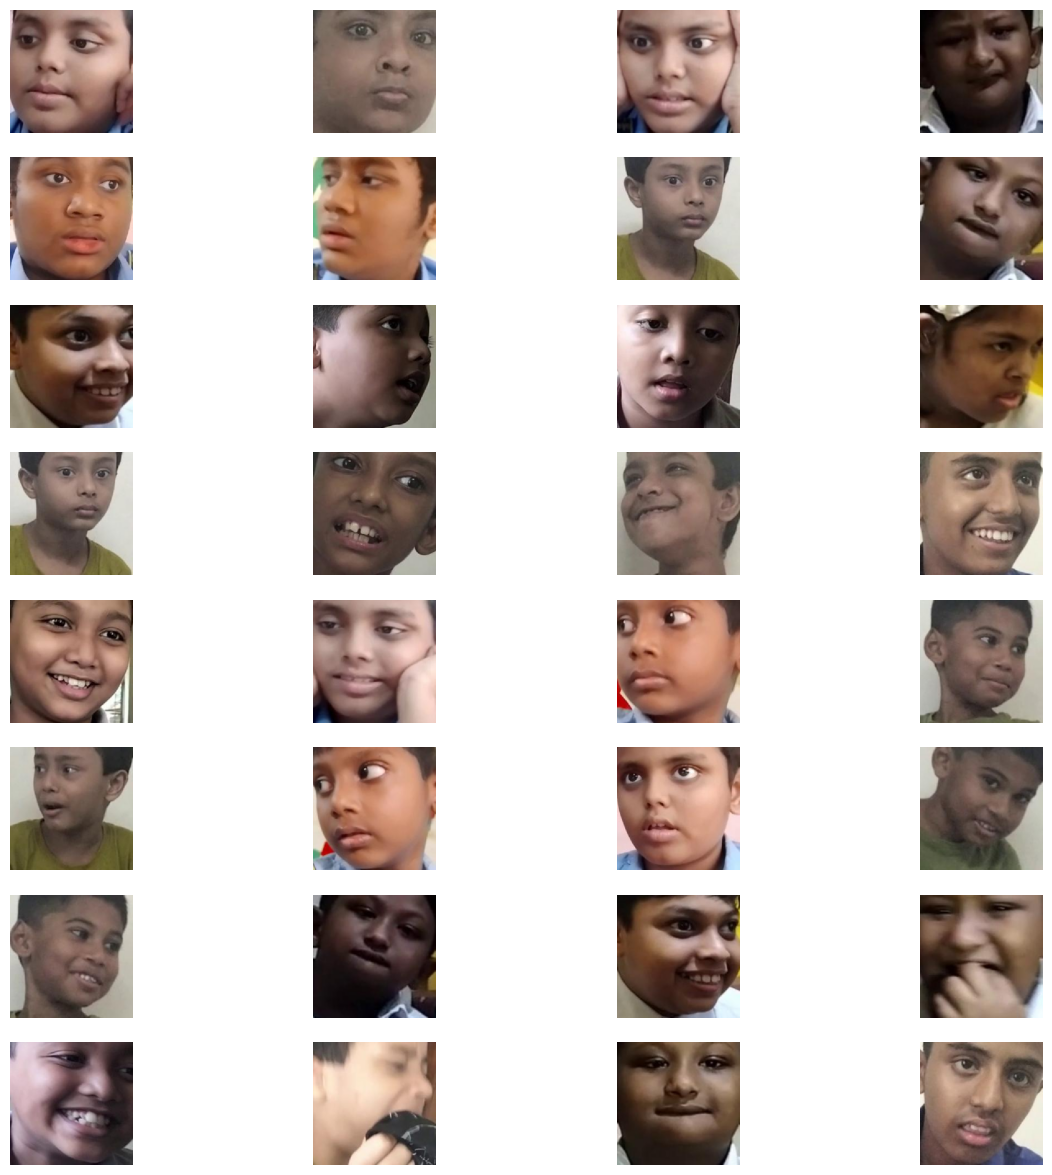

In [7]:
samples = next(val_gen)[0]


plt.figure(figsize=(15, 15))
for i, idx in enumerate(samples):
    ax = plt.subplot(int(batch_size/4), 4, i + 1)
    plt.imshow(samples[i])
    plt.axis("off")

## Modeling

In [8]:
# from model_architectures import resnet50_model as ml_model
# from model_architectures import inception_resnet_v2_model as ml_model
from model_architectures import inceptionv3_model as ml_model

In [ ]:
#model_name = 'resnet_model3_nandita'

### Training Model

In [10]:
def run_experiment(model_name, pretrained = False, Training = False):
    if pretrained:
      checkpoint_path = "model_architectures/checkpoints/"+model_name+'_pretrained_weights.h5'
    else:
      checkpoint_path = "model_architectures/checkpoints/"+model_name+'_weights.h5'


    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor= 'val_loss',
        mode = 'min',
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )

    # log_dir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1)

    model = ml_model.get_model()
    print(model.summary())

    if not Training:
      checkpoint_path = "model_architectures/final_models/"+model_name+'_collected_dataset/'+model_name+'_weights.h5'
      history_path = "model_architectures/final_models/"+model_name+'_collected_dataset/'+model_name+'_history.xlsx'


      model.load_weights(checkpoint_path)
      history = pd.read_excel(history_path)
      return model, history


    history = model.fit(train_ds,
                        steps_per_epoch = int(len(train_df))//batch_size,
                        validation_data = val_ds,
                        validation_steps = int(len(test_df))//batch_size,
                        epochs = EPOCHS,
                        callbacks = [
                            checkpoint,
                            early_stopping
                            # tensorboard_callback
                            ],
                        )

    history_file_path = 'model_architectures/histories/'+model_name+'_pretrained.xlsx'
    pd.DataFrame(history.history).to_excel(history_file_path)

    #model.load_weights(checkpoint_path)

    return model, history


In [11]:
# trained_model, history = run_experiment(model_name = model_name, pretrained = True, Training = False)
trained_model, history = run_experiment(model_name = model_name, Training = False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

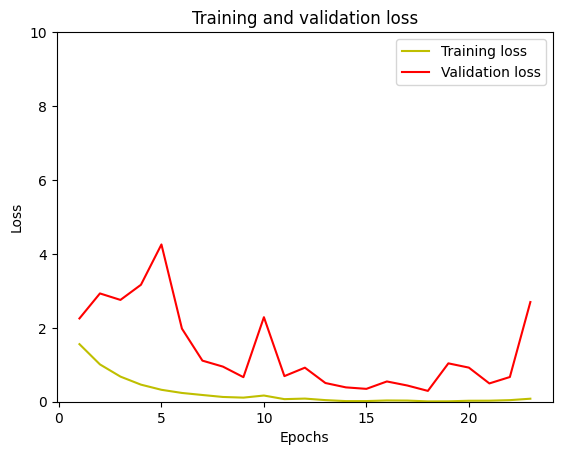

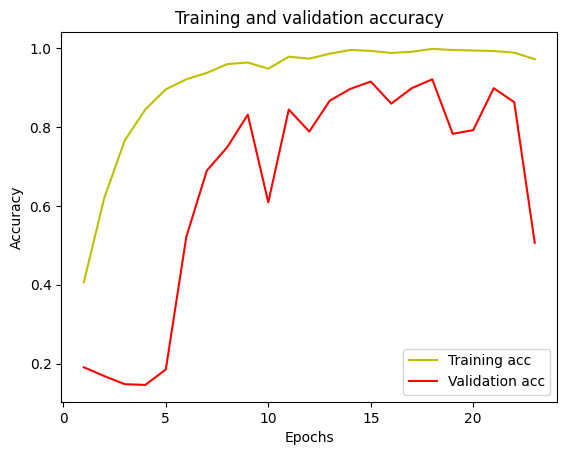

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,10))
plt.legend()
plt.show()


acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 567 validated image filenames belonging to 6 classes.
18/18 [==============================] - 50s 3s/step


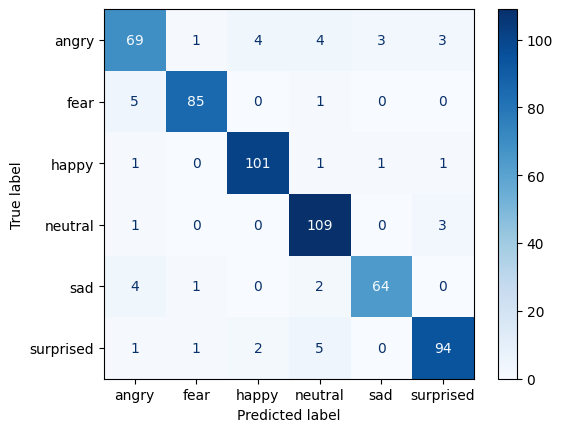

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        84
           1       0.97      0.93      0.95        91
           2       0.94      0.96      0.95       105
           3       0.89      0.96      0.93       113
           4       0.94      0.90      0.92        71
           5       0.93      0.91      0.92       103

    accuracy                           0.92       567
   macro avg       0.92      0.92      0.92       567
weighted avg       0.92      0.92      0.92       567



In [12]:
test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col = 'filepath',
    y_col = 'emotion',
    target_size=IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size = len(test_df),
    shuffle=False,

)


inputs, targets = next(test_gen)
predictions = trained_model.predict(inputs)
targets = np.argmax(targets, axis = 1)
predictions = np.argmax(np.round(predictions), axis = 1)

labels = ['angry','fear','happy','neutral','sad','surprised']

cm = confusion_matrix(targets, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(targets, predictions))

18/18 [==============================] - 47s 3s/step


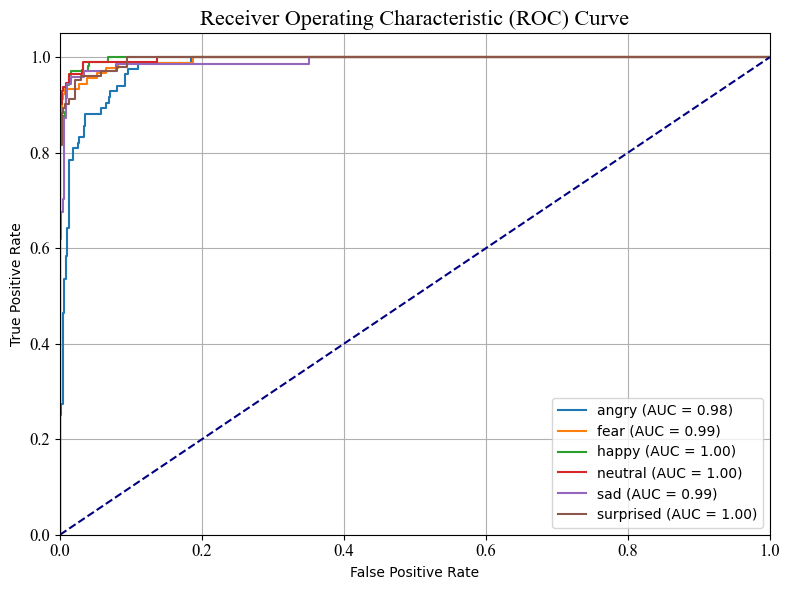

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the probability scores for each class
probabilities = trained_model.predict(inputs)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(targets, probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontname='Times New Roman', fontsize=16)
plt.legend(loc="lower right")
plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.grid(True)
plt.tight_layout()


plt.savefig('roc_curve2.png', dpi=300)
plt.show()


In [13]:
import pandas as pd

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Save DataFrame to Excel file
cm_df.to_excel('confusion_matrix3.xlsx', index=True)

print("Confusion matrix saved to 'confusion_matrix.xlsx'")



Confusion matrix saved to 'confusion_matrix.xlsx'


In [ ]:
# Opening Tensorboard
%load_ext tensorboard

## Inference

In [13]:
## Implement with threading or multiprocessing to make runtime faster

def inference(video_path, target_fps):

    cap = cv2.VideoCapture(video_path)
    labels = ['angry','fear','happy','neutral','sad','surprised']

    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps//target_fps)

    step_count = 0
    label = 'emotion'
    try:
      while True:
        ret, frame = cap.read()
        step_count = step_count+1

        if not ret:
          break

        frame = frame[:, :, [2, 1, 0]]
        face, bbox = extract_faces(frame,
                                      target_size = IMAGE_SIZE,
                                      enforce_detection = False,
                                      align = False)
        x, y, w, h = bbox
        if step_count == interval:

            face=face/255
            prediction = np.argmax(
               np.round(trained_model.predict(np.expand_dims(face, axis = 0), verbose = 0)),
               axis = 1
            )
            label  = labels[prediction[0]]
            step_count = 0


        frame = frame[:, :, [2, 1, 0]]

        frame = np.ascontiguousarray(frame, dtype=np.uint8)
        cv2.rectangle(frame, (x,y), (x+w, y + h),(0,255,0),3)
        cv2.putText(frame, label, (x,y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 1)

        cv2.imshow("Frame",frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    finally:
        cap.release()
        cv2.destroyAllWindows()

In [14]:
inference('dataset/participant_2/participant2_sad2.mp4', 1)